In [ ]:
import uuid
from IPython.display import display, HTML

def create_hide_button():
    unique_id = str(uuid.uuid4())
    display(HTML('''
        <script>
        function toggle_output(button_id) {
            var output_area = document.getElementById(button_id).parentElement.parentElement.nextElementSibling;
            var button = document.getElementById(button_id);
            if (output_area.style.display === "none") {
                output_area.style.display = "block";
                button.innerHTML = "Hide Output";
            } else {
                output_area.style.display = "none";
                button.innerHTML = "Show Output";
            }
        }
        </script>
    '''))

    button_id = f"button_{unique_id}"
    display(HTML(f'''
        <button id="{button_id}" onclick="toggle_output('{button_id}')">Show Output</button>
        <script>
            document.getElementById('{button_id}').parentElement.parentElement.nextElementSibling.style.display = 'none';
        </script>
    '''))

In [ ]:
from IPython.display import display, HTML

display(HTML('''<style>
    .jp-CodeCell .jp-InputArea {display: none;} /* Hide only code cells */
</style>'''))

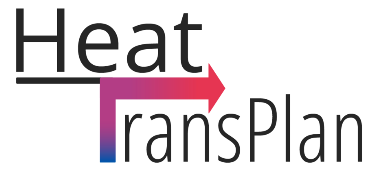


<div style="text-align: center; font-size: 50px;">
    <b>Exploratory Data Analysis</b>
</div>

In [ ]:
import pandas as pd
import random
import itertools
import os
import numpy as np
from datetime import datetime, timedelta
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
#import simulation
import simpy
import seaborn as sns
import matplotlib.pyplot as plt
import chardet
import plotly.io as pio
from pathlib import Path
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objects as go
pio.renderers.default='notebook'
pd.options.mode.chained_assignment = None

# Table of Contents

- [Process Analysis](#Process-Analysis)
- [Visualisierung von Sensorenwerten](#Visualisierung-von-Sensorenwerten)
- [Data Potentialanalyse](#Data-Potentialanalyse)


## Ideen:

- Explorationanalyse für den Prozesserhitzer
- Der Energieverbrauch variiert je nach Auftrag und Produkttyp, z. B. abhängig von Dampfleistung und Temperaturen
- Es gibt Spitzen der Dampfleistung zu Beginn und am Ende der Produktionszyklen
- Der Prozessschritt besteht aus mehreren Subprozessen; die zwei wichtigsten sind Umlauf und Produktion, in denen der meiste Energieverbrauch anfällt
- Auch der CIP‑Prozess hat einen hohen Energieverbrauch
- Zunächst Durchführung einer Potenzialanalyse auf Basis der aktuell verfügbaren Daten
- Mit einer erweiterten Datenbasis können anschließend detailliertere Potenzialanalysen für die unterschiedlichen Produkte durchgeführt werden

## Define Paths and Load Datasets

In [ ]:
# Define the path to the current file's location
current_path = Path(__file__).resolve().parent if '__file__' in globals() else Path().resolve()

# Navigate to the 'data/bronze/aixit' folder relative to the current path
files_folder_raw = current_path.parent.parent.parent.parent / 'data' / 'raw' / 'eckes_granini'

In [ ]:
files_folder_raw

In [ ]:
# Define the path to the current file's location
current_path = Path(__file__).resolve().parent if '__file__' in globals() else Path().resolve()

# Navigate to the 'data/bronze/aixit' folder relative to the current path
files_folder_bronze = current_path.parent.parent.parent.parent / 'data' / 'bronze' / 'eckes_granini'

In [ ]:
# Define the path to the current file's location
current_path = Path(__file__).resolve().parent if '__file__' in globals() else Path().resolve()

# Navigate to the 'data/silver/aixit' folder relative to the current path
files_folder_silver = current_path.parent.parent.parent.parent / 'data' / 'silver' / 'eckes_granini'

### Load Aufträge Activities Energy Sensor


In [ ]:
# load Aufträge Activities Energy Sensor
df_activities_energy_sensor = pd.read_csv(files_folder_silver/"AufträgeMeldungen_Activities_Energy_Sensor_merged.csv", low_memory=False)
print(df_activities_energy_sensor.columns)

df_activities_energy_sensor.head()

### Load Aufträge Orders Energy Sensor


In [ ]:
# load Aufträge Orders Energy Sensor
df_orders_energy_sensor = pd.read_csv(files_folder_silver/"AufträgeMeldungen_Orders_Energy_Sensor_merged.csv")
print(df_orders_energy_sensor.columns)

df_orders_energy_sensor.head()

### Load Aufträge Orders Energy Sensor in 5 Sek Interval

In [ ]:
df_energy_sensors_process_5s = pd.read_csv(files_folder_silver/"Aufträge_Energy_Sensor_merged.csv")
print(df_energy_sensors_process_5s.columns)

df_energy_sensors_process_5s.head()

# Process Analysis

Visualisierung der einzelnen Prozessschritte. Die meiste Zeit des Prozesses wird im Umlauf und im Produktionsbetrieb verbracht

In [ ]:
import pm4py
import matplotlib.pyplot as plt
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

event_log = pm4py.format_dataframe(df_activities_energy_sensor, case_id='OrderNumber', activity_key='ActivityName', timestamp_key='StartTime_Activity')
event_log['recipe'] = 'A'
map_ = pm4py.discover_heuristics_net(event_log)
gviz = hn_visualizer.apply(map_)
hn_visualizer.save(gviz, "heuristics_net.png")

# Display the image
fig, ax = plt.subplots(figsize=(30, 30))  # Adjust the width and height as needed

# Load and display the image
img = plt.imread("heuristics_net.png")
ax.imshow(img)
ax.axis('off')  # Hide the axis
ax.set_title('Process Discovery')

# Save the combined image
#plt.savefig(files_folder_bronze/"heuristics_net_status_name_eckes_granini.png")

# Show the plot
plt.show()

## Analysis on Activity Level

In [ ]:
import plotly.express as px

activity_counts = (
    df_activities_energy_sensor["ActivityName"]
    .value_counts()
    .reset_index()
)

activity_counts.columns = ["ActivityName", "Count"]

activity_counts

fig = px.bar(
    activity_counts,
    x="ActivityName",
    y="Count",
    title="Häufigste Aktivitäten",
    labels={"ActivityName": "Aktivität", "Count": "Häufigkeit"},
)

fig.update_layout(
    xaxis_tickangle=45,
    template="plotly_white",
    height=500
)

fig.show()

In [ ]:
prod = "BF 1,00 GRTG Apfel trüb S DE PET"

subset = df_activities_energy_sensor[df_activities_energy_sensor["BF Product"] == prod]

activity_counts = (
    subset["ActivityName"]
    .value_counts()
    .reset_index()
)

activity_counts.columns = ["ActivityName", "Count"]

px.bar(
    activity_counts,
    x="ActivityName",
    y="Count",
    title=f"Häufigste Aktivitäten – Beispiel Produkt {prod}",
).show()

# Visualisierung von Sensorenwerten

Hier werden verschiedene Sensoren für eine Exploration dargestellt. Die Visualisierungen sind interaktiv, sodass es möglich ist, Sensoren, Aufträge und Prozessschritte auszuwählen, um diese genauer zu betrachten.

Es zeigt sich, dass unterschiedliche Aktivitäten und Aufträge abweichende Sensorwerte aufweisen. Außerdem treten zu Beginn und am Ende von Produktionszyklen deutliche Energiespitzen auf.

## Analysis on Process Level

## Strom

## Durchschnittliche Stromleistung (kW)

### Durchschnittliche Stromleistung gesamter Prozess

In [ ]:
#Analysis kW

import plotly.graph_objects as go

# Nach Startzeit sortieren
df_orders_energy_sensor = df_orders_energy_sensor.sort_values("Start_Prozess")

# Zeitreihe vorbereiten (wie bei dir)
times = []
powers = []

for _, row in df_orders_energy_sensor.iterrows():
    # Startpunkt
    times.append(row["Start_Prozess"])
    powers.append(row["Strom_kW_avg"])

    # Endpunkt
    times.append(row["Ende_Prozess"])
    powers.append(row["Strom_kW_avg"])

# Plotly Step-Plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=times,
    y=powers,
    mode="lines",
    line=dict(shape="hv"),   # horizontale + vertikale Sprünge (Step-Plot)
    name="Durchschnittliche Stromleistung"
))

fig.update_layout(
    title="Durchschnittliche Stromleistung über die Prozesse",
    xaxis_title="Zeit",
    yaxis_title="Stromleistung (kW)",
    xaxis=dict(tickangle=90),
    template="plotly_white"
)

fig.show()

### Durchschnittliche Stromleistung je Prozessinstanz

In [ ]:
#analysis kW

import plotly.graph_objects as go

fig = go.Figure()

# Daten nach Prozess/Order gruppieren
for order_id, df_group in df_orders_energy_sensor.groupby("OrderNumber"):  
    times = []
    powers = []

    # BF Product pro Order (nehmen wir aus der ersten Zeile)
    product = df_group["Product"].iloc[0]

    # sicherheitshalber sortieren
    df_group = df_group.sort_values("Start_Prozess")

    for _, row in df_group.iterrows():
        times.append(row["Start_Prozess"])
        powers.append(row["Strom_kW_avg"])

        times.append(row["Ende_Prozess"])
        powers.append(row["Strom_kW_avg"])

    # Legendennamen erweitern
    legend_name = f"{order_id} – {product}"

    fig.add_trace(go.Scatter(
        x=times,
        y=powers,
        mode="lines",
        line=dict(shape="hv"),
        name=legend_name
    ))

fig.update_layout(
    title="Durchschnittliche Stromleistung je Prozess über die Zeit",
    xaxis_title="Zeit",
    yaxis_title="Durchschnittliche Leistung (kW)",
    template="plotly_white"
)

fig.show()

## Stromleistung (kW) Profile (5s)

### Gesamter Prozess

In [ ]:
import plotly.graph_objects as go
import pandas as pd

df = df_energy_sensors_process_5s.copy()

df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime")

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df["datetime"],
    y=df["Strom aktuell PET2 KZE"],
    mode="lines",
    name="Stromleistung (5s)"
))

fig.update_layout(
    title="Strom-Leistungsprofile über die Prozesse (5s)",
    xaxis_title="Zeit",
    yaxis_title="Stromleistung (kW)",
    template="plotly_white"
)

fig.show()

### Pro Prozessinstanz

In [ ]:
import plotly.graph_objects as go
import pandas as pd

df = df_energy_sensors_process_5s.copy()

# Zeitspalten sicher als datetime
df["datetime"] = pd.to_datetime(df["datetime"])
df["StartTime_Order"] = pd.to_datetime(df["StartTime_Order"])
df["EndTime_Order"]   = pd.to_datetime(df["EndTime_Order"])

# Nur gemappte Orders + Strom
df = df.dropna(subset=["OrderNumber", "Strom aktuell PET2 KZE"]).sort_values(["OrderNumber", "datetime"])

fig = go.Figure()

# Traces pro Order (auf Order-Zeitraum gefiltert)
groups = list(df.groupby("OrderNumber", sort=False))

for order, g in groups:
    # Order-Zeitraum (pro Order konstant)
    start = g["StartTime_Order"].iloc[0]
    end   = g["EndTime_Order"].iloc[0]

    # auf Zeitraum schneiden
    g = g[(g["datetime"] >= start) & (g["datetime"] <= end)].sort_values("datetime")

    product = g["BF Product"].iloc[0] if "BF Product" in g.columns and len(g) else ""

    fig.add_trace(go.Scatter(
        x=g["datetime"],
        y=g["Strom aktuell PET2 KZE"],
        mode="lines",
        name=f"Order {order} – {product}",
        visible=False
    ))

# erste Order sichtbar
if len(fig.data) > 0:
    fig.data[0].visible = True

# Dropdown erstellen
buttons = []
for i, (order, g) in enumerate(groups):
    product = g["BF Product"].iloc[0] if "BF Product" in g.columns else ""
    label = f"{order} – {product}" if product else f"{order}"

    visible = [False] * len(fig.data)
    visible[i] = True

    buttons.append(dict(
        label=label,
        method="update",
        args=[
            {"visible": visible},
            {"title": f"Strom-Leistungsprofil (5s) – Order {order} – {product}"}
        ]
    ))

fig.update_layout(
    title="Strom-Leistungsprofil (5s) pro Prozess",
    xaxis_title="Zeit",
    yaxis_title="Momentanleistung Strom (kW)",
    template="plotly_white",
    updatemenus=[dict(
        type="dropdown",
        x=1.05, xanchor="left",
        y=1, yanchor="top",
        buttons=buttons
    )],
    height=500
)

fig.show()

### Pro Prozessinstanz und dazugehörige Aktivitäten

In [ ]:


df = df_energy_sensors_process_5s.copy()
power_col = "Strom aktuell PET2 KZE"

df["datetime"] = pd.to_datetime(df["datetime"])
df["StartTime_Order"] = pd.to_datetime(df["StartTime_Order"])
df["EndTime_Order"]   = pd.to_datetime(df["EndTime_Order"])
df = df.dropna(subset=["OrderNumber", power_col]).sort_values("datetime")

def slice_to_order_window(dfo):
    start = dfo["StartTime_Order"].iloc[0]
    end   = dfo["EndTime_Order"].iloc[0]
    return dfo[(dfo["datetime"] >= start) & (dfo["datetime"] <= end)].sort_values("datetime")

def order_label_for(dfo, order):
    product = dfo["BF Product"].iloc[0] if "BF Product" in dfo.columns and len(dfo) else ""
    return f"Order {order} – {product}".strip(" –")

orders = df["OrderNumber"].dropna().drop_duplicates().tolist()
default_order = orders[0]

app = Dash(__name__)

app.layout = html.Div([
    html.Div([
        html.Label("Order"),
        dcc.Dropdown(
            id="order_dd",
            options=[{"label": str(o), "value": o} for o in orders],
            value=default_order,
            clearable=False
        ),
    ], style={"width": "45%", "display": "inline-block"}),

    html.Div([
        html.Label("Aktivität"),
        dcc.Dropdown(id="act_dd", clearable=False),
    ], style={"width": "45%", "display": "inline-block", "marginLeft": "2%"}),

    dcc.Graph(id="fig")
])

@app.callback(
    Output("act_dd", "options"),
    Output("act_dd", "value"),
    Input("order_dd", "value")
)
def update_activities(order):
    dfo = df[df["OrderNumber"] == order].copy()
    dfo = slice_to_order_window(dfo)
    acts = dfo["ActivityName"].dropna().drop_duplicates().tolist()
    options = [{"label": "Gesamt", "value": "__ALL__"}] + [{"label": a, "value": a} for a in acts]
    return options, "__ALL__"

@app.callback(
    Output("fig", "figure"),
    Input("order_dd", "value"),
    Input("act_dd", "value")
)
def update_figure(order, act):
    dfo = df[df["OrderNumber"] == order].copy()
    dfo = slice_to_order_window(dfo)

    olabel = order_label_for(dfo, order)
    title = f"Strom aktuell PET2 KZE – {olabel}"

    if act != "__ALL__":
        dfo = dfo[dfo["ActivityName"] == act].sort_values("datetime")
        title += f" – {act}"

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=dfo["datetime"], y=dfo[power_col],
        mode="lines",
        name=olabel if act == "__ALL__" else f"{olabel} – {act}"
    ))
    fig.update_layout(
        title=title,
        xaxis_title="Zeit",
        yaxis_title="Momentanleistung Strom (kW)",
        template="plotly_white",
        height=550
    )
    return fig

app.run(debug=True)

## Stromverbrauch (kWh) für die Prozesse

### Gesamter Prozess

In [ ]:
#Analysis kWh

import plotly.graph_objects as go

# Nach Startzeit sortieren
df_orders_energy_sensor = df_orders_energy_sensor.sort_values("Start_Prozess")

# Zeitreihe vorbereiten (wie bei dir)
times = []
powers = []

for _, row in df_orders_energy_sensor.iterrows():
    # Startpunkt
    times.append(row["Start_Prozess"])
    powers.append(row["Strom_kWh_total"])

    # Endpunkt
    times.append(row["Ende_Prozess"])
    powers.append(row["Strom_kWh_total"])

# Plotly Step-Plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=times,
    y=powers,
    mode="lines",
    line=dict(shape="hv"),   # horizontale + vertikale Sprünge (Step-Plot)
    name="Stromverbrauch"
))

fig.update_layout(
    title="Stromverbrauch über die Prozesszeit",
    xaxis_title="Zeit",
    yaxis_title="Stromverbrauch (kWh)",
    xaxis=dict(tickangle=90),
    template="plotly_white"
)

fig.show()

### Pro Prozessinstanz

In [ ]:
#analysis kWh

import plotly.graph_objects as go

fig = go.Figure()

# Daten nach Prozess/Order gruppieren
for order_id, df_group in df_orders_energy_sensor.groupby("OrderNumber"):  
    times = []
    powers = []

    # BF Product pro Order (nehmen wir aus der ersten Zeile)
    product = df_group["Product"].iloc[0]

    # sicherheitshalber sortieren
    df_group = df_group.sort_values("Start_Prozess")

    for _, row in df_group.iterrows():
        times.append(row["Start_Prozess"])
        powers.append(row["Strom_kWh_total"])

        times.append(row["Ende_Prozess"])
        powers.append(row["Strom_kWh_total"])

    # Legendennamen erweitern
    legend_name = f"{order_id} – {product}"

    fig.add_trace(go.Scatter(
        x=times,
        y=powers,
        mode="lines",
        line=dict(shape="hv"),
        name=legend_name
    ))

fig.update_layout(
    title="Stromverbrauch je Prozess über die Zeit",
    xaxis_title="Zeit",
    yaxis_title="Stromverbrauch (kWh)",
    template="plotly_white"
)

fig.show()

## Dampf

## Durchschnittliche Dampfleistung (kg/h)

### Durchschnittliche Dampfleistung (kg/h) für die Prozesse

In [ ]:
#Analysis kg/h

import plotly.graph_objects as go

# Nach Startzeit sortieren
df_orders_energy_sensor = df_orders_energy_sensor.sort_values("Start_Prozess")

# Zeitreihe vorbereiten (wie bei dir)
times = []
powers = []

for _, row in df_orders_energy_sensor.iterrows():
    # Startpunkt
    times.append(row["Start_Prozess"])
    powers.append(row["Dampf_kg_h_avg"])

    # Endpunkt
    times.append(row["Ende_Prozess"])
    powers.append(row["Dampf_kg_h_avg"])

# Plotly Step-Plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=times,
    y=powers,
    mode="lines",
    line=dict(shape="hv"),   # horizontale + vertikale Sprünge (Step-Plot)
    name="Durchschnittliche Dampfleistung"
))

fig.update_layout(
    title="Durchschnittliche Dampfleistung über die Prozesse",
    xaxis_title="Zeit",
    yaxis_title="Dampfleistung (kg/h)",
    xaxis=dict(tickangle=90),
    template="plotly_white"
)

fig.show()

### Durchschnittliche Dampfleistung je Prozessinstanz

In [ ]:
#analysis kgh

import plotly.graph_objects as go

fig = go.Figure()

# Daten nach Prozess/Order gruppieren
for order_id, df_group in df_orders_energy_sensor.groupby("OrderNumber"):  
    times = []
    powers = []

    # BF Product pro Order (nehmen wir aus der ersten Zeile)
    product = df_group["Product"].iloc[0]

    # sicherheitshalber sortieren
    df_group = df_group.sort_values("Start_Prozess")

    for _, row in df_group.iterrows():
        times.append(row["Start_Prozess"])
        powers.append(row["Dampf_kg_h_avg"])

        times.append(row["Ende_Prozess"])
        powers.append(row["Dampf_kg_h_avg"])

    # Legendennamen erweitern
    legend_name = f"{order_id} – {product}"

    fig.add_trace(go.Scatter(
        x=times,
        y=powers,
        mode="lines",
        line=dict(shape="hv"),
        name=legend_name
    ))

fig.update_layout(
    title="Durchschnittliche Dampfleistung je Prozess über die Zeit",
    xaxis_title="Zeit",
    yaxis_title="Durchschnittliche Dampfleistung (kg/h)",
    template="plotly_white"
)

fig.show()

## Dampfleistung (kg/h) Profile (5s)

### Gesamter Prozess

In [ ]:
df = df_energy_sensors_process_5s.copy()

df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime")

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df["datetime"],
    y=df["Dampf aktuell PET2 KZE 30120FT801"],
    mode="lines",
    name="Dampfleistung (5s)"
))

fig.update_layout(
    title="Dampf-Leistungsprofile über die Prozesse (5s)",
    xaxis_title="Zeit",
    yaxis_title="Dampfleistung (kg/h)",
    template="plotly_white"
)

fig.show()

### Pro Prozessinstanz

In [ ]:
import plotly.graph_objects as go
import pandas as pd

df = df_energy_sensors_process_5s.copy()

# Zeitspalten sicher als datetime
df["datetime"] = pd.to_datetime(df["datetime"])
df["StartTime_Order"] = pd.to_datetime(df["StartTime_Order"])
df["EndTime_Order"]   = pd.to_datetime(df["EndTime_Order"])

# Nur gemappte Orders + Dampf
df = df.dropna(subset=["OrderNumber", "Dampf aktuell PET2 KZE 30120FT801"]).sort_values(["OrderNumber", "datetime"])

fig = go.Figure()

# Traces pro Order (auf Order-Zeitraum gefiltert)
groups = list(df.groupby("OrderNumber", sort=False))

for order, g in groups:
    # Order-Zeitraum (pro Order konstant)
    start = g["StartTime_Order"].iloc[0]
    end   = g["EndTime_Order"].iloc[0]

    # auf Zeitraum schneiden
    g = g[(g["datetime"] >= start) & (g["datetime"] <= end)].sort_values("datetime")

    product = g["BF Product"].iloc[0] if "BF Product" in g.columns and len(g) else ""

    fig.add_trace(go.Scatter(
        x=g["datetime"],
        y=g["Dampf aktuell PET2 KZE 30120FT801"],
        mode="lines",
        name=f"Order {order} – {product}",
        visible=False
    ))

# erste Order sichtbar
if len(fig.data) > 0:
    fig.data[0].visible = True

# Dropdown erstellen
buttons = []
for i, (order, g) in enumerate(groups):
    product = g["BF Product"].iloc[0] if "BF Product" in g.columns else ""
    label = f"{order} – {product}" if product else f"{order}"

    visible = [False] * len(fig.data)
    visible[i] = True

    buttons.append(dict(
        label=label,
        method="update",
        args=[
            {"visible": visible},
            {"title": f"Dampf-Leistungsprofil (5s) – Order {order} – {product}"}
        ]
    ))

fig.update_layout(
    title="Dampf-Leistungsprofil (5s) pro Prozess",
    xaxis_title="Zeit",
    yaxis_title="Momentanleistung Dampf (kg/h)",
    template="plotly_white",
    updatemenus=[dict(
        type="dropdown",
        x=1.05, xanchor="left",
        y=1, yanchor="top",
        buttons=buttons
    )],
    height=500
)

fig.show()

### Pro Prozessinstanz und dazugehöriger Aktivität

In [ ]:
df = df_energy_sensors_process_5s.copy()
power_col = "Dampf aktuell PET2 KZE 30120FT801"

df["datetime"] = pd.to_datetime(df["datetime"])
df["StartTime_Order"] = pd.to_datetime(df["StartTime_Order"])
df["EndTime_Order"]   = pd.to_datetime(df["EndTime_Order"])
df = df.dropna(subset=["OrderNumber", power_col]).sort_values("datetime")

def slice_to_order_window(dfo):
    start = dfo["StartTime_Order"].iloc[0]
    end   = dfo["EndTime_Order"].iloc[0]
    return dfo[(dfo["datetime"] >= start) & (dfo["datetime"] <= end)].sort_values("datetime")

def order_label_for(dfo, order):
    product = dfo["BF Product"].iloc[0] if "BF Product" in dfo.columns and len(dfo) else ""
    return f"Order {order} – {product}".strip(" –")

orders = df["OrderNumber"].dropna().drop_duplicates().tolist()
default_order = orders[0]

app = Dash(__name__)

app.layout = html.Div([
    html.Div([
        html.Label("Order"),
        dcc.Dropdown(
            id="order_dd",
            options=[{"label": str(o), "value": o} for o in orders],
            value=default_order,
            clearable=False
        ),
    ], style={"width": "45%", "display": "inline-block"}),

    html.Div([
        html.Label("Aktivität"),
        dcc.Dropdown(id="act_dd", clearable=False),
    ], style={"width": "45%", "display": "inline-block", "marginLeft": "2%"}),

    dcc.Graph(id="fig")
])

@app.callback(
    Output("act_dd", "options"),
    Output("act_dd", "value"),
    Input("order_dd", "value")
)
def update_activities(order):
    dfo = df[df["OrderNumber"] == order].copy()
    dfo = slice_to_order_window(dfo)
    acts = dfo["ActivityName"].dropna().drop_duplicates().tolist()
    options = [{"label": "Gesamt", "value": "__ALL__"}] + [{"label": a, "value": a} for a in acts]
    return options, "__ALL__"

@app.callback(
    Output("fig", "figure"),
    Input("order_dd", "value"),
    Input("act_dd", "value")
)
def update_figure(order, act):
    dfo = df[df["OrderNumber"] == order].copy()
    dfo = slice_to_order_window(dfo)

    olabel = order_label_for(dfo, order)
    title = f"Dampf aktuell PET2 KZE 30120FT801 – {olabel}"

    if act != "__ALL__":
        dfo = dfo[dfo["ActivityName"] == act].sort_values("datetime")
        title += f" – {act}"

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=dfo["datetime"], y=dfo[power_col],
        mode="lines",
        name=olabel if act == "__ALL__" else f"{olabel} – {act}"
    ))
    fig.update_layout(
        title=title,
        xaxis_title="Zeit",
        yaxis_title="Momentanleistung Dampf (kg/h)",
        template="plotly_white",
        height=550
    )
    return fig

app.run(debug=True)

## Dampfverbrauch (kg) für die Prozesse

### Gesamter Prozess

In [ ]:
#Analysis kg

import plotly.graph_objects as go

# Nach Startzeit sortieren
df_orders_energy_sensor = df_orders_energy_sensor.sort_values("Start_Prozess")

# Zeitreihe vorbereiten (wie bei dir)
times = []
powers = []

for _, row in df_orders_energy_sensor.iterrows():
    # Startpunkt
    times.append(row["Start_Prozess"])
    powers.append(row["Dampf_kg_total"])

    # Endpunkt
    times.append(row["Ende_Prozess"])
    powers.append(row["Dampf_kg_total"])

# Plotly Step-Plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=times,
    y=powers,
    mode="lines",
    line=dict(shape="hv"),   # horizontale + vertikale Sprünge (Step-Plot)
    name="Dampfverbrauch"
))

fig.update_layout(
    title="Dampfverbrauch über die Prozesszeit",
    xaxis_title="Zeit",
    yaxis_title="Dampfverbrauch (kg)",
    xaxis=dict(tickangle=90),
    template="plotly_white"
)

fig.show()

### Pro Prozessinstanz

In [ ]:
#analysis kg

import plotly.graph_objects as go

fig = go.Figure()

# Daten nach Prozess/Order gruppieren
for order_id, df_group in df_orders_energy_sensor.groupby("OrderNumber"):  
    times = []
    powers = []

    # BF Product pro Order (nehmen wir aus der ersten Zeile)
    product = df_group["Product"].iloc[0]

    # sicherheitshalber sortieren
    df_group = df_group.sort_values("Start_Prozess")

    for _, row in df_group.iterrows():
        times.append(row["Start_Prozess"])
        powers.append(row["Dampf_kg_total"])

        times.append(row["Ende_Prozess"])
        powers.append(row["Dampf_kg_total"])

    # Legendennamen erweitern
    legend_name = f"{order_id} – {product}"

    fig.add_trace(go.Scatter(
        x=times,
        y=powers,
        mode="lines",
        line=dict(shape="hv"),
        name=legend_name
    ))

fig.update_layout(
    title="Dampfverbrauch je Prozess über die Zeit",
    xaxis_title="Zeit",
    yaxis_title="Dampfverbrauch (kg)",
    template="plotly_white"
)

fig.show()

## Temperatur Produkt Einlauf 30110TT01

## Durchschnittliche Temperatur

### Durchschnittliche Temperatur für die Prozesse

In [ ]:
#Analysis kg/h

import plotly.graph_objects as go

# Nach Startzeit sortieren
df_orders_energy_sensor = df_orders_energy_sensor.sort_values("Start_Prozess")

# Zeitreihe vorbereiten (wie bei dir)
times = []
powers = []

for _, row in df_orders_energy_sensor.iterrows():
    # Startpunkt
    times.append(row["Start_Prozess"])
    powers.append(row["temp_Produkt_Einlauf_30110TT001"])

    # Endpunkt
    times.append(row["Ende_Prozess"])
    powers.append(row["temp_Produkt_Einlauf_30110TT001"])

# Plotly Step-Plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=times,
    y=powers,
    mode="lines",
    line=dict(shape="hv"),   # horizontale + vertikale Sprünge (Step-Plot)
    name="Durchschnittliche Temperatur"
))

fig.update_layout(
    title="Durchschnittliche Temperatur Produkt Einlauf 30110TT001 über die Prozesse",
    xaxis_title="Zeit",
    yaxis_title="Temperatur (°C)",
    xaxis=dict(tickangle=90),
    template="plotly_white"
)

fig.show()

### Durchschnittliche Temperatur je Prozessinstanz

In [ ]:
fig = go.Figure()

# Daten nach Prozess/Order gruppieren
for order_id, df_group in df_orders_energy_sensor.groupby("OrderNumber"):  
    times = []
    powers = []

    # BF Product pro Order (nehmen wir aus der ersten Zeile)
    product = df_group["Product"].iloc[0]

    # sicherheitshalber sortieren
    df_group = df_group.sort_values("Start_Prozess")

    for _, row in df_group.iterrows():
        times.append(row["Start_Prozess"])
        powers.append(row["temp_Produkt_Einlauf_30110TT001"])

        times.append(row["Ende_Prozess"])
        powers.append(row["temp_Produkt_Einlauf_30110TT001"])

    # Legendennamen erweitern
    legend_name = f"{order_id} – {product}"

    fig.add_trace(go.Scatter(
        x=times,
        y=powers,
        mode="lines",
        line=dict(shape="hv"),
        name=legend_name
    ))

fig.update_layout(
    title="Durchschnittliche Temperatur Produkt Einlauf 30110TT001 je Prozess über die Zeit",
    xaxis_title="Zeit",
    yaxis_title="Temperatur (°C)",
    template="plotly_white"
)

fig.show()

## Temperaturprofile (1h)

### Gesamter Prozess

In [ ]:
df = df_energy_sensors_process_5s.copy()

df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime")

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df["datetime"],
    y=df["temp_Produkt_Einlauf_30110TT001_1h"],
    mode="lines",
    name="Temperatur (1h)"
))

fig.update_layout(
    title="Temperatur Produkt Einlauf 30110TT001 über die Prozesse (1h)",
    xaxis_title="Zeit",
    yaxis_title="Temperatur (°C)",
    template="plotly_white"
)

fig.show()

### Pro Prozessinstanz

In [ ]:
df = df_energy_sensors_process_5s.copy()

# Zeitspalten sicher als datetime
df["datetime"] = pd.to_datetime(df["datetime"])
df["StartTime_Order"] = pd.to_datetime(df["StartTime_Order"])
df["EndTime_Order"]   = pd.to_datetime(df["EndTime_Order"])

# Nur gemappte Orders + Temperatur
df = df.dropna(subset=["OrderNumber", "temp_Produkt_Einlauf_30110TT001_1h"]).sort_values(["OrderNumber", "datetime"])

fig = go.Figure()

# Traces pro Order (auf Order-Zeitraum gefiltert)
groups = list(df.groupby("OrderNumber", sort=False))

for order, g in groups:
    # Order-Zeitraum (pro Order konstant)
    start = g["StartTime_Order"].iloc[0]
    end   = g["EndTime_Order"].iloc[0]

    # auf Zeitraum schneiden
    g = g[(g["datetime"] >= start) & (g["datetime"] <= end)].sort_values("datetime")

    product = g["BF Product"].iloc[0] if "BF Product" in g.columns and len(g) else ""

    fig.add_trace(go.Scatter(
        x=g["datetime"],
        y=g["temp_Produkt_Einlauf_30110TT001_1h"],
        mode="lines",
        name=f"Order {order} – {product}",
        visible=False
    ))

# erste Order sichtbar
if len(fig.data) > 0:
    fig.data[0].visible = True

# Dropdown erstellen
buttons = []
for i, (order, g) in enumerate(groups):
    product = g["BF Product"].iloc[0] if "BF Product" in g.columns else ""
    label = f"{order} – {product}" if product else f"{order}"

    visible = [False] * len(fig.data)
    visible[i] = True

    buttons.append(dict(
        label=label,
        method="update",
        args=[
            {"visible": visible},
            {"title": f"Temperatur Produkt Einlauf 30110TT001 (1h) – Order {order} – {product}"}
        ]
    ))

fig.update_layout(
    title="Temperatur Produkt Einlauf 30110TT001 (1h) pro Prozess",
    xaxis_title="Zeit",
    yaxis_title="Temperatur (°C)",
    template="plotly_white",
    updatemenus=[dict(
        type="dropdown",
        x=1.05, xanchor="left",
        y=1, yanchor="top",
        buttons=buttons
    )],
    height=500
)

fig.show()

### Pro Prozessinstanz und dazugehöriger Aktivität

In [ ]:
df = df_energy_sensors_process_5s.copy()
power_col = "temp_Produkt_Einlauf_30110TT001_1h"

df["datetime"] = pd.to_datetime(df["datetime"])
df["StartTime_Order"] = pd.to_datetime(df["StartTime_Order"])
df["EndTime_Order"]   = pd.to_datetime(df["EndTime_Order"])
df = df.dropna(subset=["OrderNumber", power_col]).sort_values("datetime")

def slice_to_order_window(dfo):
    start = dfo["StartTime_Order"].iloc[0]
    end   = dfo["EndTime_Order"].iloc[0]
    return dfo[(dfo["datetime"] >= start) & (dfo["datetime"] <= end)].sort_values("datetime")

def order_label_for(dfo, order):
    product = dfo["BF Product"].iloc[0] if "BF Product" in dfo.columns and len(dfo) else ""
    return f"Order {order} – {product}".strip(" –")

orders = df["OrderNumber"].dropna().drop_duplicates().tolist()
default_order = orders[0]

app = Dash(__name__)

app.layout = html.Div([
    html.Div([
        html.Label("Order"),
        dcc.Dropdown(
            id="order_dd",
            options=[{"label": str(o), "value": o} for o in orders],
            value=default_order,
            clearable=False
        ),
    ], style={"width": "45%", "display": "inline-block"}),

    html.Div([
        html.Label("Aktivität"),
        dcc.Dropdown(id="act_dd", clearable=False),
    ], style={"width": "45%", "display": "inline-block", "marginLeft": "2%"}),

    dcc.Graph(id="fig")
])

@app.callback(
    Output("act_dd", "options"),
    Output("act_dd", "value"),
    Input("order_dd", "value")
)
def update_activities(order):
    dfo = df[df["OrderNumber"] == order].copy()
    dfo = slice_to_order_window(dfo)
    acts = dfo["ActivityName"].dropna().drop_duplicates().tolist()
    options = [{"label": "Gesamt", "value": "__ALL__"}] + [{"label": a, "value": a} for a in acts]
    return options, "__ALL__"

@app.callback(
    Output("fig", "figure"),
    Input("order_dd", "value"),
    Input("act_dd", "value")
)
def update_figure(order, act):
    dfo = df[df["OrderNumber"] == order].copy()
    dfo = slice_to_order_window(dfo)

    olabel = order_label_for(dfo, order)
    title = f"Temperatur Produkt Einlauf 30110TT001 (1h) – {olabel}"

    if act != "__ALL__":
        dfo = dfo[dfo["ActivityName"] == act].sort_values("datetime")
        title += f" – {act}"

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=dfo["datetime"], y=dfo[power_col],
        mode="lines",
        name=olabel if act == "__ALL__" else f"{olabel} – {act}"
    ))
    fig.update_layout(
        title=title,
        xaxis_title="Zeit",
        yaxis_title="Temperatur (°C)",
        template="plotly_white",
        height=550
    )
    return fig

app.run(debug=True)

# Data Potentialanalyse

Hierbei werden wichtige Variablen für die Energiebedarfsmodellierung und die Wärmeintegrationsanalyse ausgewählt und weiter visualisiert. Es zeigt sich, dass die Werte dieser Variablen je nach Produkt deutlich voneinander abweichen.

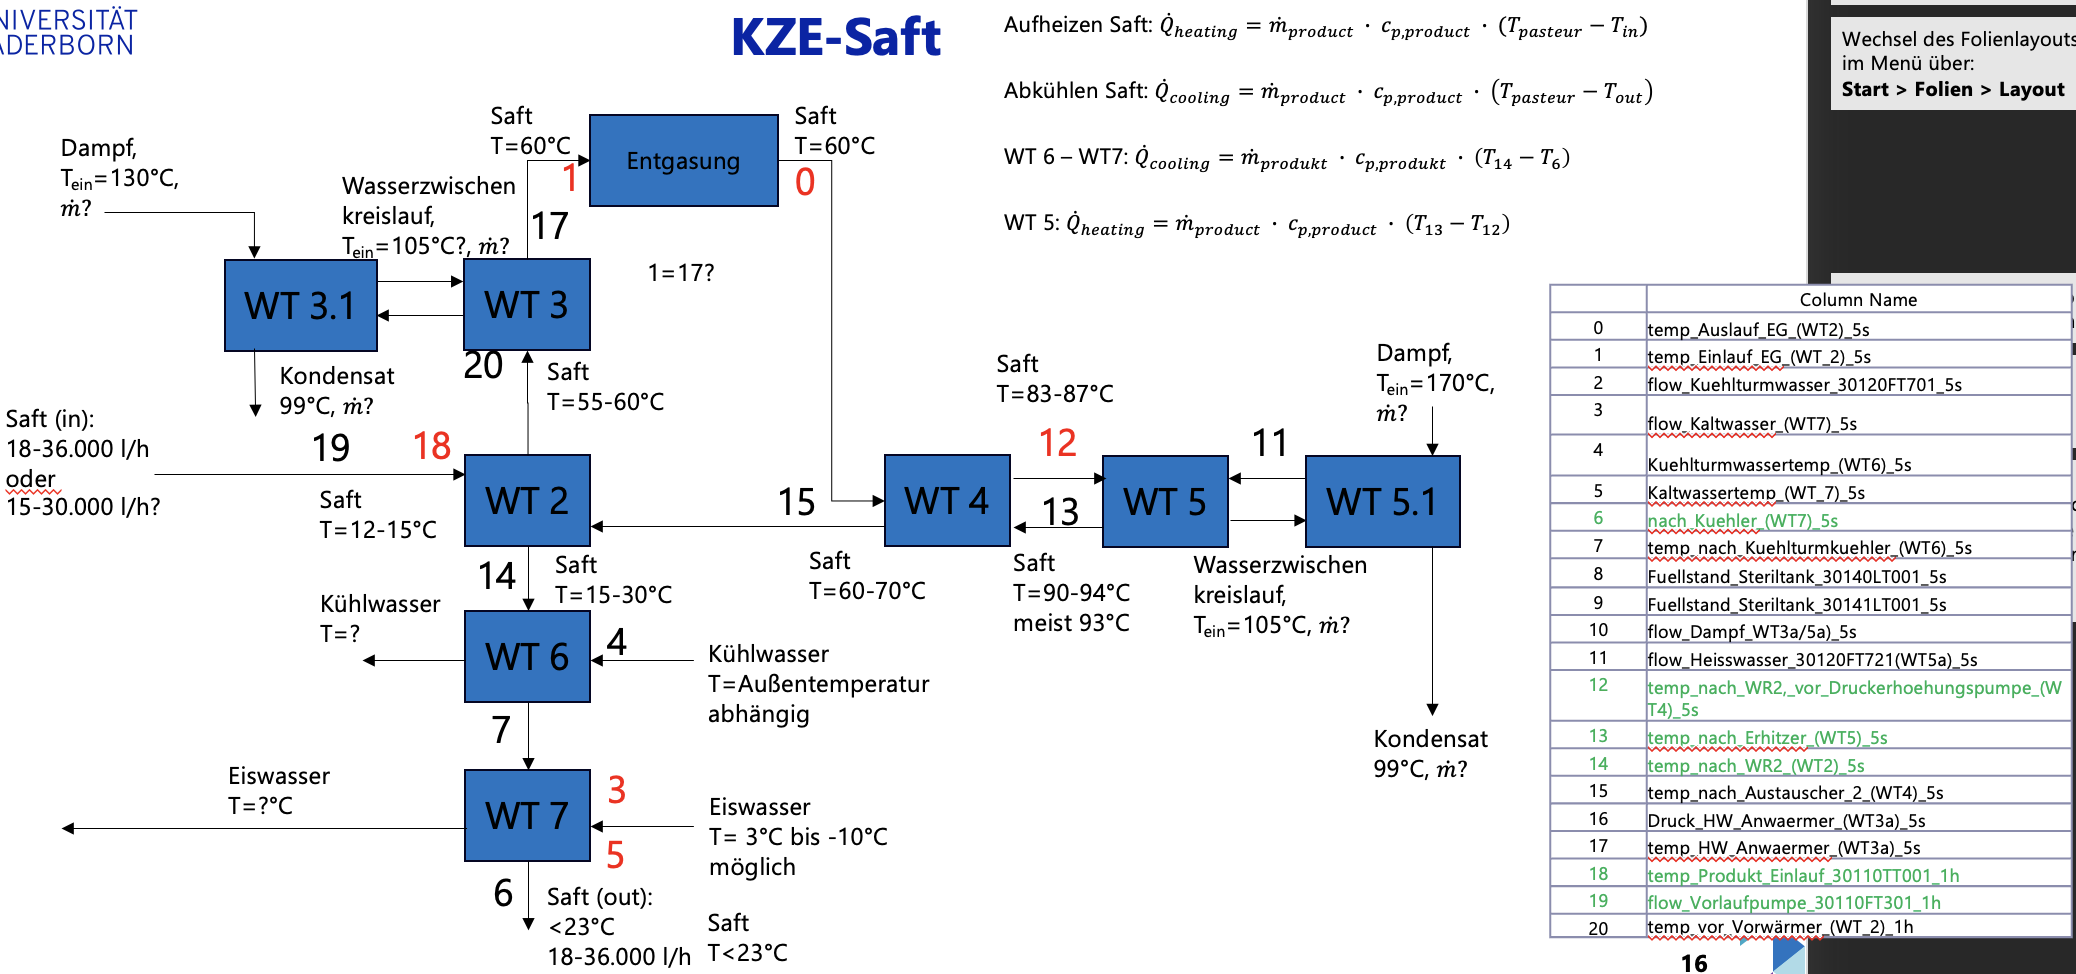

In [ ]:
df_energy_sensors_process_5s

In [ ]:
df_energy_sensors_process_5s.columns

In [ ]:
df = df_energy_sensors_process_5s.copy()

replace_dict = {

                'temp_Produkt_Einlauf_30110TT001_1h': '(18)_temp_Produkt_Einlauf_30110TT001_1h', # Produkt Tin
                'flow_Vorlaufpumpe_30110FT301_1h': '(19)_flow_Vorlaufpumpe_30110FT301_1h', # Produkt Durchfluss

                'temp_nach_WR2_(WT2)_5s': '(14)_temp_nach_WR2_(WT2)_5s', #. Temp vor dem kuehler 
                'nach_Kuehler_(WT7)_5s': '(6)_nach_Kuehler_(WT7)_5s', # Produkt Tout

                'temp_nach_Erhitzer_(WT5)_5s': '(13)_temp_nach_Erhitzer_(WT5)_5s', # Produkt Tpasteur



                'temp_vor_Vorwärmer_(WT_2)_1h': '(20)_temp_vor_Vorwärmer_(WT_2)_1h', # Temp nach WT3
                'temp_nach_WR2,_vor_Druckerhoehungspumpe_(WT4)_5s': '(12)_temp_nach_WR2,_vor_Druckerhoehungspumpe_(WT4)_5s', # Vor dem Erhitzer


                }

density_juice = 1.05  # kg/L
cp_juice = 3.8  # kJ/kgK

# df = df[relevant_sensors].copy()
df = df.rename(columns=replace_dict)

df['(19)_mass_Vorlaufpumpe_30110FT301_1h'] = df['(19)_flow_Vorlaufpumpe_30110FT301_1h'] * density_juice # Produkt massenstrom


df['(30)_aufheizen_saft'] = df['(19)_mass_Vorlaufpumpe_30110FT301_1h'] * cp_juice * (df['(13)_temp_nach_Erhitzer_(WT5)_5s'] - df['(18)_temp_Produkt_Einlauf_30110TT001_1h']) / 3600  # kW -> Qheating
df['(31)_kuehlen_saft'] = df['(19)_mass_Vorlaufpumpe_30110FT301_1h'] * cp_juice * (df['(13)_temp_nach_Erhitzer_(WT5)_5s'] -df['(6)_nach_Kuehler_(WT7)_5s']) / 3600  # kW -> Qcooling


df_calcualted = df.copy()


In [ ]:
relevant_sensors = [
    '(18)_temp_Produkt_Einlauf_30110TT001_1h',
    '(19)_flow_Vorlaufpumpe_30110FT301_1h',
    '(14)_temp_nach_WR2_(WT2)_5s',
    '(6)_nach_Kuehler_(WT7)_5s',
    '(12)_temp_nach_WR2,_vor_Druckerhoehungspumpe_(WT4)_5s',
    '(13)_temp_nach_Erhitzer_(WT5)_5s',
    '(19)_mass_Vorlaufpumpe_30110FT301_1h',
    '(30)_aufheizen_saft',
    '(31)_kuehlen_saft',
    'flow_Dampf_WT3a/5a)_5s',
    'BF Product',
    'ActivityName'
]

In [ ]:
df_calcualted['ActivityName'].value_counts()

In [ ]:
df = df_calcualted[["datetime", "OrderNumber"] + relevant_sensors].copy()

# df = df[df['ActivityName'].isin(['Erhitzer Step-030 = Produktion', 'Erhitzer Step-032 = Umlauf'])].copy()

df_relevant = df.copy()

df_relevant.describe().T.reset_index().rename(columns={"index": "Sensor"})

In [ ]:
df = df_calcualted[["datetime", "OrderNumber"] + relevant_sensors].copy()

df = df[df['ActivityName'].isin(['Erhitzer Step-030 = Produktion', 'Erhitzer Step-032 = Umlauf'])].copy()

df_relevant = df.copy()

df_relevant.describe().T.reset_index().rename(columns={"index": "Sensor"})

In [ ]:
df_relevant.columns

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Select numeric columns for aggregation
numeric_cols = df_relevant.select_dtypes(include=['number']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['OrderNumber']]  # Exclude non-relevant

# Aggregate df_relevant by 'BF Product' using mean on numeric columns only
df_agg = df_relevant.groupby('BF Product')[numeric_cols].mean().reset_index()

# Number of subplots
n_cols = 2
n_rows = math.ceil(len(numeric_cols) / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten axes for easy iteration
axes = axes.flatten()

# For each variable, plot distribution of means across products
for i, col in enumerate(numeric_cols):
    sns.histplot(data=df_agg, x=col, kde=True, bins=50, ax=axes[i])
    axes[i].set_title(f'Distribution of Mean {col} across BF Products')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()